## DNN for forecasting on synthetic time series data

In [1]:
# import libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Utility functions to generate data and plot

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

### Generate Data

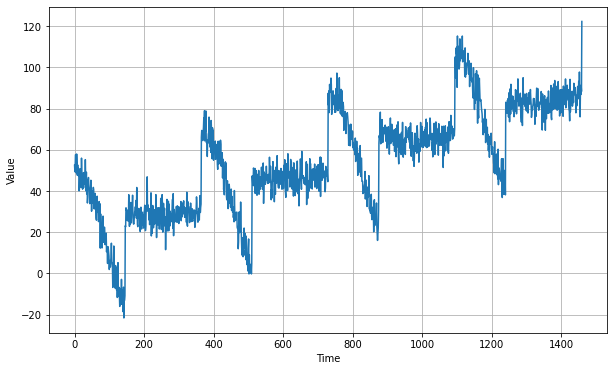

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split into train and validation data

In [4]:
split_time = 1000

train_series = series[:split_time]
train_time = time[:split_time]

valid_series = series[split_time:]
valid_time = time[split_time:]

print('Shape of train series: {}'.format(train_series.shape))
print('Shape of valid series :{}'.format(valid_series.shape))

Shape of train series: (1000,)
Shape of valid series :(461,)


### PrePare the data for training

In [6]:
# define the parameters
buffer_size = 1000
batch_size = 32
window_size = 20

In [8]:
## function to generate windowed datasets

def generate_windowed_dataset(series, buffer_size, batch_size, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # window_size + 1 : as we will be using last column as the label for each window
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    
    # flatten
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    
    # create features and labels
    dataset = dataset.map(lambda window : (window[:-1], window[-1]))
    
    # shuffle the dataset
    dataset = dataset.shuffle(buffer_size=buffer_size)
    
    # create batches 
    dataset = dataset.batch(batch_size=batch_size)
    
    # will return a dataset that contains tuples of features and labels
    return dataset

In [9]:
# generate dataset using the train data
dataset = generate_windowed_dataset(train_series, buffer_size, batch_size, window_size)

In [10]:
## get one sample from dataset and check

for data in dataset.take(1):
    print('Type of data : {}'.format(type(data)))
    print('Length :{}'.format(len(data)))
    print('Shape of the feature data : {}'.format(data[0].shape))
    print('Shape of the label data : {}'.format(data[1].shape))

Type of data : <class 'tuple'>
Length :2
Shape of the feature data : (32, 20)
Shape of the label data : (32,)


### Create DNN Model and compile

In [12]:
# initialize and compile the model

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation = 'relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
]) 

# check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [13]:
# compile the model

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
              loss = 'mse')

In [14]:
# fit the model
model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 34ms/step - loss: 765.8020
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 132.7284
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 108.5151
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 99.9517
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 94.2003
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 89.7554
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 85.8664
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 83.6581
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 81.4160
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 79.1518
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 77.5103
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 75.0677
Epoch 13/100
31/31 [=

### Predict using a single batch

In [19]:
# set the sample test data
test_sample = np.array(series[0:20])

print('Shape of test sample  :{}'.format(test_sample.shape))

# reshape 
test_sample = np.expand_dims(test_sample, axis = 0)
print('Shape of test sample  :{}'.format(test_sample.shape))

Shape of test sample  :(20,)
Shape of test sample  :(1, 20)


In [20]:
## predict using the test sample data
model.predict(test_sample)

1/1 [==============================] - 0s 111ms/step


array([[45.21186]], dtype=float32)

In [23]:
## check the true values
series[0:21]

array([52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
       57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
       50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
       44.454983, 41.76799 , 55.980938], dtype=float32)

### Predict on the validation data

In [25]:
## prepare the validation data for prediction

# data to be used by model for predicting: starting from the split time - window size index 
# as we will be using a window size for predicting 
data_for_forecast = series[split_time - window_size :]

# to store forecast_data
forecast = []

for i in range(len(data_for_forecast) - window_size):
    
    forecast.append(model.predict(np.expand_dims(data_for_forecast[i:i + window_size], axis = 0)))
    
# convert forecast into a numpy array
forecast = np.array(forecast)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


In [26]:
## check the shape of the forecast
print('Shape of forecast : {}'.format(forecast.shape))

Shape of forecast : (461, 1, 1)


- We will need to squeeze this to plot and compare

In [28]:
squeezed_forecast = forecast.squeeze()

squeezed_forecast.shape

(461,)

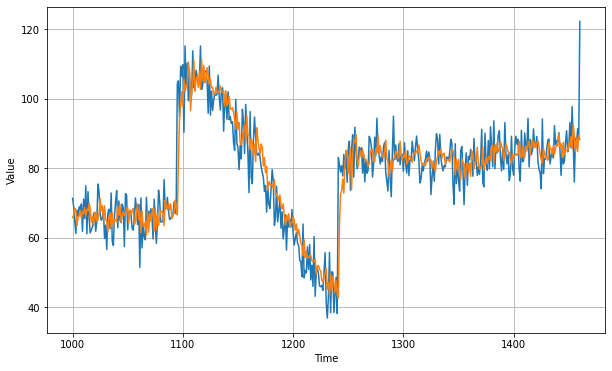

In [29]:
# plot and compare

plot_series(valid_time, (valid_series, squeezed_forecast))

In [36]:
squeezed_forecast.shape

(461,)

In [38]:
## evaluation metrics

def get_evaluation_metrics(true, predicted):
    
    print('Mean Squared Error : {}'.format(tf.keras.metrics.mean_squared_error(true, predicted).numpy()))
    print('Mean Absolute Error : {}'.format(tf.keras.metrics.mean_absolute_error(true, predicted).numpy()))

In [39]:
get_evaluation_metrics(valid_series, squeezed_forecast)

Mean Squared Error : 45.239967346191406
Mean Absolute Error : 5.011638164520264


- Lets make these metrics the based metrics
- We'll look on improving the performance of the model
- First, we will try to find the tune the learning rate value and will try to find the best learning rate value

### Tune learning rate

In [58]:
## re-create the same model

# initialize and compile the model

model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation = 'relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
]) 

# check model summary
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                210       
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


We will declare a [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback. This will allow to dynamically set the learning rate based on the epoch number during training. As shown below, we will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [59]:
## set up the learning rate schedular
## this will start the learning rate value from 1e-8 at epoch 0 and then gradually increase 

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

In [60]:
## compile the model
## we are setting the default learning rate 0.01 of SGD, this will be replaced by value given from  lr_schedule

model_tune.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
             loss='mse')

In [61]:
## fit the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 6444.0117 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 4459.3726 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 3074.4087 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 2164.6616 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 1539.3777 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 1088.0317 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 773.5247 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 574.1127 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 423.9091 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 302.2228 - lr: 2.8184e-08
Epo

31/31 [==============================] - 0s 2ms/step - loss: 932.0281 - lr: 1.2589e-04
Epoch 84/100
31/31 [==============================] - 0s 1ms/step - loss: 896.8166 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 0s 2ms/step - loss: 822.3206 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 0s 2ms/step - loss: 751.6149 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 0s 2ms/step - loss: 687.3454 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 0s 1ms/step - loss: 631.3994 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 0s 1ms/step - loss: 583.2662 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 0s 1ms/step - loss: 544.3528 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 0s 1ms/step - loss: 513.2083 - lr: 3.1623e-04
Epoch 92/100
31/31 [==============================] - 0s 1ms/step - loss: 489.6074 - lr: 3.5481e-04
Epoch 93/100


- We can see the learning value scaled up as it goes through the traning epochs
- Lets plot and see how the loss values changes w.r.t to the learning value

In [63]:
import pandas as pd
results = pd.DataFrame(history.history)

results

# plt.figure(figsize = (12, 8))
# plt.plot(results['lr'], results['loss'])

,loss,lr
0,6444.011719,1.000000e-08
1,4459.372559,1.122018e-08
2,3074.408691,1.258925e-08
3,2164.661621,1.412538e-08
4,1539.377686,1.584893e-08
...,...,...
95,449.437073,5.623413e-04
96,446.906433,6.309574e-04
97,445.929657,7.079458e-04
98,445.299866,7.943282e-04


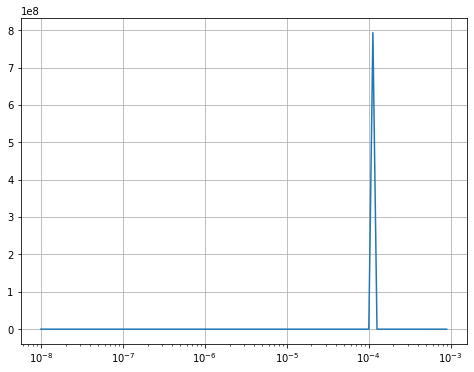

In [74]:
# plot and check 
plt.figure(figsize=(8, 6))
plt.semilogx(results['lr'], results['loss'])
plt.grid(True)
plt.show();

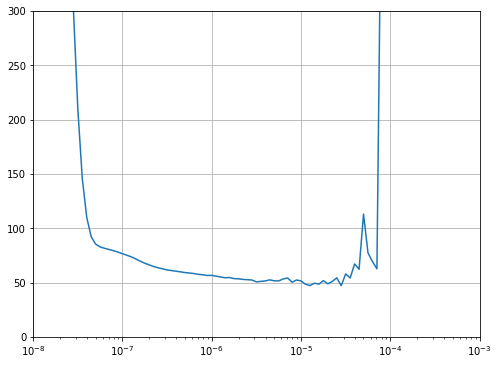

In [72]:
# focusing on the points between 0 and 300
# plot and check 
plt.figure(figsize=(8, 6))
plt.semilogx(results['lr'], results['loss'])
plt.axis([1e-8,1e-3, 0, 300])
plt.grid(True)
plt.show();

Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.

In [75]:
# # Define the learning rate array
# lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# # Set the figure size
# plt.figure(figsize=(10, 6))

# # Set the grid
# plt.grid(True)

# # Plot the loss in log scale
# plt.semilogx(lrs, history.history["loss"])

# # Increase the tickmarks size
# plt.tick_params('both', length=10, width=1, which='both')

# # Set the plot boundaries
# plt.axis([1e-8, 1e-3, 0, 300])

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, we will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will see in the next cells.

First, lets initialize the same model architecture again.

### Setting up the final model based on the learning rate

In [121]:
## final model

final_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation = 'relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
]) 

# check model summary
final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 10)                210       
                                                                 
 dense_24 (Dense)            (None, 10)                110       
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


- I'll choose the learning rate 1.2e-5

In [122]:
# compile the model

final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1.2e-5, momentum=0.9),
                   loss = 'mse')

In [123]:
# fit the model
history_final = final_model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 593.9648
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 94.8723
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 70.6408
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 62.8812
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 59.5991
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 57.6768
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 62.1926
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 57.5181
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 62.5569
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 69.2144
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 55.2587
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 51.2749
Epoch 13/100
31/31 [====

### get the predictions and compare with the true values

In [124]:
## get predictions from the final model

data_for_forecast = series[split_time - window_size :]

# to store forecast_data
forecast_final = []

for i in range(len(data_for_forecast) - window_size):
    
    forecast_final.append(final_model.predict(np.expand_dims(data_for_forecast[i:i + window_size], axis = 0)))
    
# convert forecast into a numpy array
forecast_final = np.array(forecast_final)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


In [125]:
# plot and compare with the true values

squeezed_forecast = forecast_final.squeeze()

squeezed_forecast.shape

(461,)

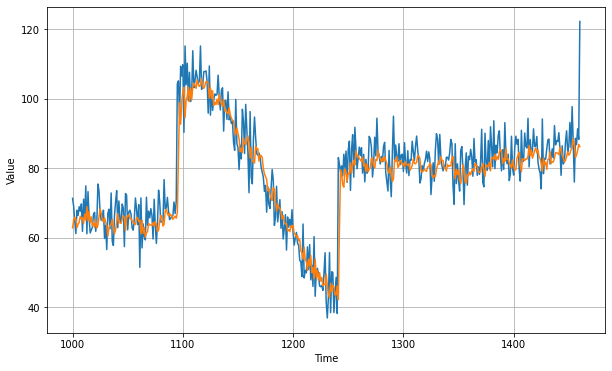

In [126]:
# plot and check

plot_series(valid_time, (valid_series, squeezed_forecast))

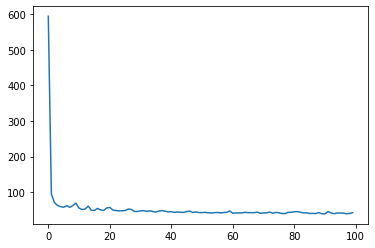

In [127]:
final_metrics = pd.DataFrame(history_final.history)

epoch_range = range(100)

plt.plot(epoch_range, final_metrics['loss'])
plt.show();

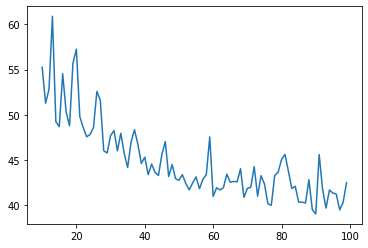

In [128]:
final_metrics = pd.DataFrame(history_final.history)

epoch_range = range(100)

plt.plot(epoch_range[10:], final_metrics['loss'][10:])
plt.show();

In [129]:
## evaluation metrics

get_evaluation_metrics(valid_series, squeezed_forecast)

Mean Squared Error : 44.09025955200195
Mean Absolute Error : 4.858056545257568
